In [19]:
import openmc
import urllib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import os

In [3]:
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/H/1'
filename, headers = urllib.request.urlretrieve(url,'h1.endf')

In [4]:
h_in_zrh = openmc.data.ThermalScattering.from_njoy('h1.endf','endf_ZrH/HinZrH/tape20',temperatures=[293.6], stdout=True, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')


 njoy 2016.60  05Aug20                                       10/21/20 14:58:02
 *****************************************************************************

 reconr...                                                                0.0s

 broadr...                                                                0.0s

 thermr...                                                                0.2s

 wrote thermal data for temp = 2.9360E+02                                 5.4s

 thermr...                                                                5.4s

 ***warning***maximum value of beta limits the allowed energy transfer
 the sct approx. will be used for transfers larger than  1.973 ev.

 wrote thermal data for temp = 2.9360E+02                                65.5s

 acer...                                                                 65.6s
                                                                         72.2s
 **************************************************************

In [5]:
if os.path.exists("c_H_in_ZrH.h5"):
    os.remove("c_H_in_ZrH.h5")
h_in_zrh.export_to_hdf5('c_H_in_ZrH.h5')

In [6]:
!{'cp c_H_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}

# Materials

In [7]:
uo2 = openmc.Material(1, "uo2")
uo2.add_nuclide('U235', 0.04)
uo2.add_nuclide('U238', 0.96)
uo2.add_nuclide('O16' , 2.00)
uo2.set_density('g/cm3', 10.0)

zrh = openmc.Material(2, "zrh")
zrh.add_element('Zr', 1.0)
zrh.add_element('H' , 1.0)
zrh.set_density('g/cm3', 5.8)
zrh.add_s_alpha_beta('c_H_in_ZrH')


In [8]:
mats = openmc.Materials([uo2, zrh])
mats.export_to_xml()


# Geometry

In [14]:
pitch = 1.26
left    = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right   = openmc.XPlane(x0= pitch/2, boundary_type='reflective')
bottom  = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top     = openmc.YPlane(y0= pitch/2, boundary_type='reflective')
fuel_or = openmc.ZCylinder(r=0.3)

fuel_region = -fuel_or
mod_region  = +left & -right & +bottom & -top & +fuel_or

fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

moderator = openmc.Cell(2, 'moderator')
moderator.fill = zrh
moderator.region = mod_region

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)


In [15]:
root = openmc.Universe(cells=(fuel, moderator))
geom = openmc.Geometry(root)
geom.export_to_xml()

# Settings

In [16]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

In [17]:
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.export_to_xml()


# Run

In [18]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
with open('my_ZrH/ZrH_projected_dos.dat','r') as f:
    lines = f.readlines()[1:]
    E,dos1,dos2,dos3,dos4 = [],[],[],[],[]
    for line in lines:
        E.append(float(line.split()[0])*0.00413566553853809)
        dos1.append(float(line.split()[1]))
        dos2.append(float(line.split()[2]))
        dos3.append(float(line.split()[3]))
        dos4.append(float(line.split()[4]))
        
    #plt.plot(E,dos1,label='1')
    #plt.plot(E,dos2,label='2')
    #plt.plot(E,dos3,label='3')
    #plt.plot(E,dos4,label='4')
    #plt.legend(loc='best')

    dos_Zr = [(dos1[i]+dos2[i])*0.5 for i in range(len(E)) if E[i] > 0]
    dos_H  = [(dos3[i]+dos4[i])*0.5 for i in range(len(E)) if E[i] > 0]
    E = [Eval for Eval in E if Eval > 0]
    #plt.plot(E,dos_Zr)
    #plt.plot(E,dos_H )
    
    E_uniform = [E[0]+(E[1]-E[0])*i for i in range(len(E)-1)]
    f_Zr = interp1d(E,dos_Zr)
    dos_Zr = f_Zr(E_uniform)
    f_H  = interp1d(E,dos_H)
    dos_H  = f_H(E_uniform)
    E = E_uniform[:]
    plt.plot(E,dos_Zr)
    plt.plot(E,dos_H)
    
    print('rho spacing = ',E[1]-E[0])
    print('rho length  = ',len(E))
    

rho spacing =  0.0009425823001405723
rho length  =  183


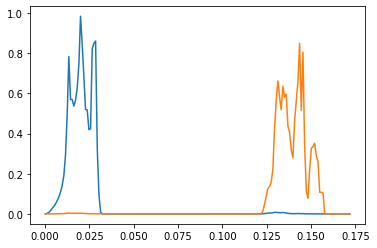

In [32]:
with open('my_ZrH2/ZrH2_projected_dos.dat','r') as f:
    lines = f.readlines()[1:]
    E,dos1,dos2,dos3,dos4,dos5,dos6 = [],[],[],[],[],[],[]
    for line in lines:
        E.append(float(line.split()[0])*0.00413566553853809)
        dos1.append(float(line.split()[1]))
        dos2.append(float(line.split()[2]))
        dos3.append(float(line.split()[3]))
        dos4.append(float(line.split()[4]))
        dos5.append(float(line.split()[5]))
        dos6.append(float(line.split()[6]))
        
    #plt.plot(E,dos1,label='1')
    #plt.plot(E,dos2,label='2')
    #plt.plot(E,dos3,label='3')
    #plt.plot(E,dos4,label='4')
    #plt.plot(E,dos4,label='5')
    #plt.plot(E,dos4,label='6')
    #plt.legend(loc='best')

    dos_Zr = [(dos1[i]+dos2[i])*0.5 for i in range(len(E)) if E[i] > 0]
    dos_H  = [(dos3[i]+dos4[i]+dos5[i]+dos6[i])*0.25 for i in range(len(E)) if E[i] > 0]
    E = [Eval for Eval in E if Eval > 0]
    #plt.plot(E,dos_Zr)
    #plt.plot(E,dos_H )
    
    E_uniform = [E[0]+(E[1]-E[0])*i for i in range(len(E)-1)]
    f_Zr = interp1d(E,dos_Zr)
    dos_Zr = f_Zr(E_uniform)
    f_H  = interp1d(E,dos_H)
    dos_H  = f_H(E_uniform)
    E = E_uniform[:]
    plt.plot(E,dos_Zr)
    plt.plot(E,dos_H)
    
    print('rho spacing = ',E[1]-E[0])
    print('rho length  = ',len(E))
    

In [34]:
dos_Zr

array([1.69545700e-04, 2.73732300e-03, 7.25456540e-03, 1.52394804e-02,
       2.68568543e-02, 3.67395600e-02, 4.90932333e-02, 6.55192271e-02,
       8.40711245e-02, 1.07539173e-01, 1.40209909e-01, 1.89515018e-01,
       2.91430207e-01, 4.89798143e-01, 7.83171396e-01, 5.69808921e-01,
       5.69563593e-01, 5.37109175e-01, 5.65627331e-01, 6.24703755e-01,
       7.43148358e-01, 9.83799269e-01, 8.44321291e-01, 6.84695111e-01,
       5.19948282e-01, 5.17471796e-01, 4.19275603e-01, 4.23530985e-01,
       8.22663911e-01, 8.48415723e-01, 8.60582440e-01, 3.27324790e-01,
       9.59309941e-02, 9.79564278e-03, 4.29793267e-11, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      